In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(findFiles('/content/drive/My Drive/data/data/names/*.txt'))

['/content/drive/My Drive/data/data/names/Arabic.txt', '/content/drive/My Drive/data/data/names/Dutch.txt', '/content/drive/My Drive/data/data/names/Czech.txt', '/content/drive/My Drive/data/data/names/Chinese.txt', '/content/drive/My Drive/data/data/names/Greek.txt', '/content/drive/My Drive/data/data/names/German.txt', '/content/drive/My Drive/data/data/names/French.txt', '/content/drive/My Drive/data/data/names/Japanese.txt', '/content/drive/My Drive/data/data/names/Irish.txt', '/content/drive/My Drive/data/data/names/Italian.txt', '/content/drive/My Drive/data/data/names/English.txt', '/content/drive/My Drive/data/data/names/Polish.txt', '/content/drive/My Drive/data/data/names/Portuguese.txt', '/content/drive/My Drive/data/data/names/Korean.txt', '/content/drive/My Drive/data/data/names/Russian.txt', '/content/drive/My Drive/data/data/names/Spanish.txt', '/content/drive/My Drive/data/data/names/Vietnamese.txt', '/content/drive/My Drive/data/data/names/Scottish.txt']


In [4]:
import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/My Drive/data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [8]:
print(all_categories)

['Arabic', 'Dutch', 'Czech', 'Chinese', 'Greek', 'German', 'French', 'Japanese', 'Irish', 'Italian', 'English', 'Polish', 'Portuguese', 'Korean', 'Russian', 'Spanish', 'Vietnamese', 'Scottish']


In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [10]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [11]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [12]:
n_letters

57

#### Defining RNN model

In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [14]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [15]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7919, -2.8135, -2.9170, -2.8296, -2.8149, -2.9174, -2.9847, -2.9797,
         -2.9004, -2.9410, -2.9694, -2.9667, -2.9331, -2.9184, -2.8410, -2.8624,
         -2.9375, -2.7511]], grad_fn=<LogSoftmaxBackward>)


#### Defining Basic LSTM model

In [17]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()

        self.hidden_size = hidden_size

        self.lstm_cell = nn.LSTM(input_size, hidden_size, num_layers = 1)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm_cell(input.view(1,1,-1), hidden)  # hidden = (hidden state, cell state)
        #print(hidden[0].shape)
        output = self.h2o(hidden[0])  # taking hidden state
        output = self.softmax(output)
        return output.view(1,-1), hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)) # hidden state and hidden cell state
# Reshaping is done bcz lstm takes input as 3D tensor only.
n_hidden = 128
lstm = LSTMNet(n_letters, n_hidden, n_categories)

In [18]:
lstm

LSTMNet(
  (lstm_cell): LSTM(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [19]:
input = letterToTensor('A')
hidden = (torch.zeros(1,1, n_hidden), torch.zeros(1,1, n_hidden))

output, next_hidden = lstm(input, hidden)

In [20]:
input = lineToTensor('Albert')
hidden = (torch.zeros(1,1, n_hidden), torch.zeros(1,1, n_hidden))

output, next_hidden = lstm(input[0], hidden)
print(output)

tensor([[-2.8567, -2.9570, -2.8086, -2.9249, -2.9202, -2.9006, -2.8904, -2.8539,
         -2.9529, -2.8741, -2.9101, -2.8557, -2.8390, -2.9410, -2.9709, -2.7963,
         -2.8717, -2.9247]], grad_fn=<ViewBackward>)


In [25]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 10)


In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Costa
category = Arabic / line = Baz
category = French / line = Lamar
category = Irish / line = O'Gorman
category = Polish / line = Bartosz
category = Chinese / line = Chew
category = Irish / line = O'Reilly
category = Japanese / line = Tsuji
category = Korean / line = Rim
category = Vietnamese / line = Dang


In [27]:
criterion = nn.NLLLoss()

#### Training the model

In [66]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(model, category_tensor, line_tensor):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

#### Plot for rnn model (lr = 0.005)

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.9291 Phocas / Arabic ✗ (Greek)
10000 10% (0m 14s) 1.3971 Vu / Vietnamese ✓
15000 15% (0m 22s) 0.9166 Quang / Vietnamese ✓
20000 20% (0m 29s) 1.1536 Wasem / Arabic ✓
25000 25% (0m 37s) 2.9483 Harger / French ✗ (Czech)
30000 30% (0m 45s) 2.8640 Paterson / Scottish ✗ (English)
35000 35% (0m 53s) 4.2427 Yagupa / Japanese ✗ (Russian)
40000 40% (1m 0s) 1.0324 Chung / Chinese ✗ (Korean)
45000 45% (1m 8s) 1.4177 Chu / Vietnamese ✗ (Korean)
50000 50% (1m 15s) 2.9785 Alsop / Scottish ✗ (English)
55000 55% (1m 22s) 2.4107 Weisener / German ✗ (Czech)
60000 60% (1m 30s) 1.1974 Patril / Czech ✓
65000 65% (1m 37s) 1.2824 Langford / English ✓
70000 70% (1m 45s) 0.6022 Yuan / Chinese ✓
75000 75% (1m 52s) 1.8370 Rahal / Irish ✗ (Arabic)
80000 80% (2m 0s) 2.3521 Tosell / French ✗ (Spanish)
85000 85% (2m 7s) 1.0945 Pereira / Portuguese ✓
90000 90% (2m 15s) 0.4034 Uehara / Japanese ✓
95000 95% (2m 22s) 0.8271 Ibarra / Spanish ✓
100000 100% (2m 29s) 1.4392 Duguay / Scottish ✗ (French)


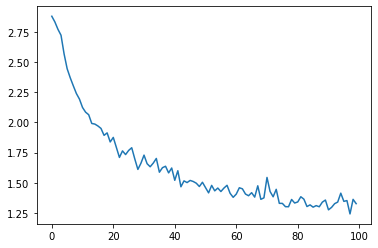

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

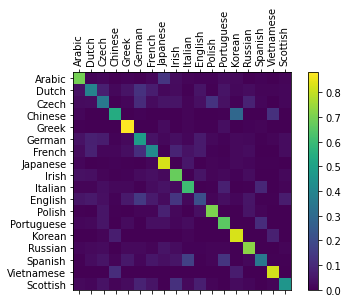

In [31]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [32]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.33) Russian
(-1.45) Czech
(-3.79) English

> Jackson
(-1.30) Scottish
(-1.44) Russian
(-1.50) English

> Satoshi
(-0.41) Japanese
(-2.08) Arabic
(-2.30) Italian


#### Plot for lstm model (lr = 0.005)

In [33]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses1 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(lstm, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses1.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 2.8663 Sowka / Russian ✗ (Polish)
10000 10% (0m 46s) 2.8338 Herrmann / English ✗ (German)
15000 15% (1m 9s) 2.8501 Michel / Irish ✗ (Polish)
20000 20% (1m 33s) 2.9071 Mcguire / Dutch ✗ (Irish)
25000 25% (1m 57s) 1.8131 Guo / Chinese ✓
30000 30% (2m 20s) 2.0907 Fujioka / Japanese ✓
35000 35% (2m 43s) 1.9447 Perugia / Japanese ✗ (Italian)
40000 40% (3m 8s) 1.1814 Chellos / Greek ✓
45000 45% (3m 31s) 1.1027 Gai / Chinese ✓
50000 50% (3m 55s) 1.2428 Xie / Chinese ✓
55000 55% (4m 19s) 0.5072 Christodoulou / Greek ✓
60000 60% (4m 42s) 1.3657 Han / Vietnamese ✗ (Korean)
65000 65% (5m 6s) 1.0219 Von wegberg / German ✓
70000 70% (5m 30s) 1.2363 Cameron / French ✗ (Scottish)
75000 75% (5m 54s) 0.7067 Salamanca / Spanish ✓
80000 80% (6m 18s) 0.7731 Calpis / Greek ✓
85000 85% (6m 42s) 1.2123 San / Chinese ✗ (Korean)
90000 90% (7m 6s) 3.5651 Thayer / Arabic ✗ (French)
95000 95% (7m 31s) 0.8025 Aonghuis / Irish ✓
100000 100% (7m 55s) 4.4379 Michel / German ✗ (Polish)


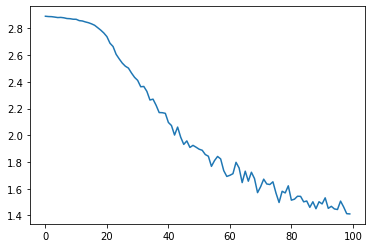

In [40]:
plt.figure()
plt.plot(all_losses1)

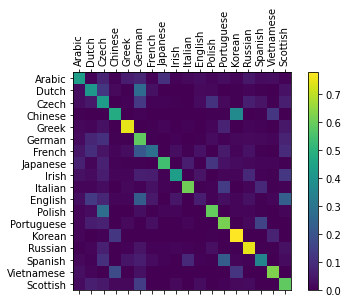

In [35]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [41]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.85) Russian
(-1.31) Czech
(-2.02) Polish

> Jackson
(-0.59) Scottish
(-2.01) Czech
(-2.19) English

> Satoshi
(-0.97) Japanese
(-1.68) Italian
(-1.76) Polish


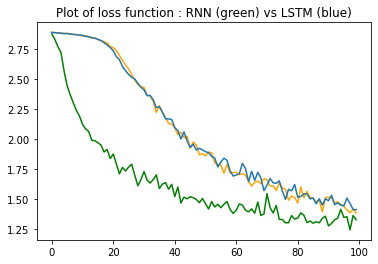

In [49]:
plt.plot(all_losses, c = "green")
plt.plot(lstm_all_losses, c = "orange") # when batch_first = True for lstm model
plt.plot(all_losses1)
plt.title("Plot of loss function : RNN (green) vs LSTM (blue)")
plt.show();

#### Plot of rnn model (lr = 0.01)

In [62]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 0.0852 Antonopoulos / Greek ✓
10000 10% (0m 15s) 1.7968 Tudor / English ✓
15000 15% (0m 23s) 0.5285 Yim / Korean ✓
20000 20% (0m 31s) 1.3271 Robert / Dutch ✗ (French)
25000 25% (0m 39s) 0.6243 Suh / Korean ✓
30000 30% (0m 47s) 2.7030 Aodha / Arabic ✗ (Irish)
35000 35% (0m 55s) 0.8080 Yuan / Chinese ✓
40000 40% (1m 3s) 0.6131 D'cruze / Portuguese ✓
45000 45% (1m 11s) 1.3650 Etxeberria / Spanish ✓
50000 50% (1m 19s) 0.6329 David / French ✓
55000 55% (1m 27s) 7.8106 Loi / Chinese ✗ (Russian)
60000 60% (1m 36s) 0.0311 O'Hannagain / Irish ✓
65000 65% (1m 46s) 2.0366 StrakaO / Dutch ✗ (Czech)
70000 70% (1m 55s) 2.6346 Muir / German ✗ (Scottish)
75000 75% (2m 3s) 1.4790 Campbell / Dutch ✗ (Scottish)
80000 80% (2m 11s) 0.5913 Vispovatyh / Russian ✓
85000 85% (2m 19s) 0.5618 Smeets / Dutch ✓
90000 90% (2m 27s) 0.9441 Mah / Vietnamese ✗ (Chinese)
95000 95% (2m 35s) 0.1196 Izumi / Japanese ✓
100000 100% (2m 43s) 0.6608 Leveque / French ✓


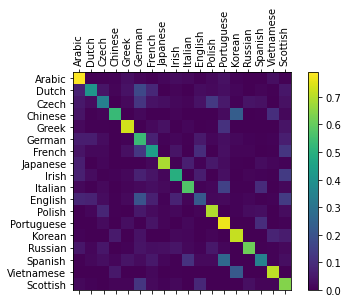

In [68]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

#### Plot of lstm model (lr = 0.01)

In [63]:
# Keep track of losses for plotting
current_loss = 0
all_losses1 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(lstm, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses1.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 24s) 0.0276 Filipowski / Polish ✓
10000 10% (0m 50s) 1.7320 Schultheiss / Dutch ✗ (German)
15000 15% (1m 15s) 0.4809 Tahan / Arabic ✓
20000 20% (1m 40s) 0.5523 Severijns / Dutch ✓
25000 25% (2m 4s) 0.0589 Utagawa / Japanese ✓
30000 30% (2m 29s) 0.5347 Rocco / Italian ✓
35000 35% (2m 53s) 0.6569 Gravari / Greek ✓
40000 40% (3m 17s) 0.0035 Katayanagi / Japanese ✓
45000 45% (3m 42s) 0.1575 Hadad / Arabic ✓
50000 50% (4m 7s) 0.0068 Assaf / Arabic ✓
55000 55% (4m 32s) 0.5695 Kijek / Polish ✓
60000 60% (4m 57s) 0.7181 Garcia / Portuguese ✓
65000 65% (5m 21s) 3.6050 Lucas / Spanish ✗ (English)
70000 70% (5m 46s) 2.2877 Cerv / Russian ✗ (Czech)
75000 75% (6m 10s) 0.0009 O'Meara / Irish ✓
80000 80% (6m 35s) 3.8873 Plouvin / French ✗ (English)
85000 85% (7m 0s) 9.9246 Ohara / Japanese ✗ (English)
90000 90% (7m 25s) 3.1192 Mcmahon / Irish ✗ (English)
95000 95% (7m 49s) 0.0148 O'Malley / Irish ✓
100000 100% (8m 14s) 0.4736 Zinin / Russian ✓


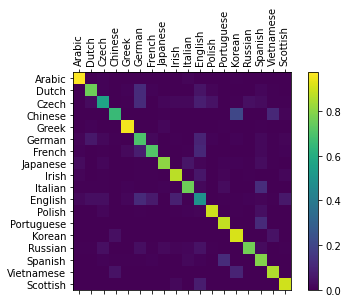

In [67]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

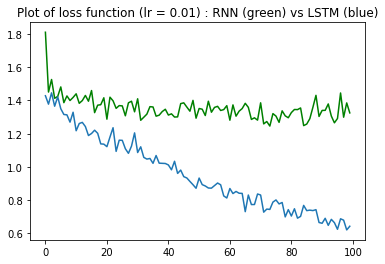

In [64]:
# lr = 0.01
plt.plot(all_losses, c = "green")
plt.plot(all_losses1)
plt.title("Plot of loss function (lr = 0.01) : RNN (green) vs LSTM (blue)")
plt.show();

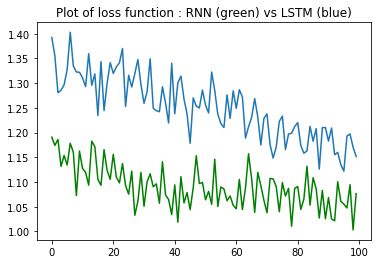

In [60]:
# lr = 0.001
plt.plot(all_losses, c = "green")
plt.plot(all_losses1)
plt.title("Plot of loss function : RNN (green) vs LSTM (blue)")
plt.show();

**Summary**

For lr = 0.01, lstm model perform much better than rnn model whereas for smaller learning rates such as 0.001 and 0.005, rnn model perform better than lstm model. 